In [1]:
import numpy as np
import pandas as pd

from pyqubo import Array
import neal
import matplotlib.pyplot as plt
import requests
import seaborn as sns


In [2]:
# Project: feature selection for credit scoring
class FeatureSelection_v1(object):
    def __init__(self, num_features, dependence_coefficients, influence_coefficients, alpha):
        self.alpha = alpha
        
        # Number of features
        self.num_features = num_features
        self.dependence_coefficients = dependence_coefficients
        self.influence_coefficients = influence_coefficients
        
        # Create binary variables for the features
        self.array = Array.create('feature', shape=self.num_features, vartype='BINARY')

    def influence(self):
        # Objective: Maximize influence of the features
        H = sum(-self.influence_coefficients[i] * self.array[i] for i in range(self.num_features))
        return self.alpha * H
        
    def dependency(self):
        # Objective: Minimize dependency among the features
        H = sum(self.dependence_coefficients[i][j] * self.array[i] * self.array[j] 
                for i in range(self.num_features) for j in range(i + 1, self.num_features))
        return (1 - self.alpha) * H



In [3]:
# 初始化一個集合來儲存所有選中的特徵
all_selected_features = set()

# 初始化一個字典來儲存每個 class 的 selected_features
class_selected_features = {}

# Load the CSV file
for i in range(0, 6):
    # Load the class 0~6 CSV file
    file_path = f'../data_p/quantum_data.address_class{i}.csv'
    df = pd.read_csv(file_path)

    # Extracting each column as an array
    columns = df.columns
    features = df[columns[:-1]]  # All columns except the last one
    result = df[columns[-1]]    # The last column
    n_features = features.shape[1]

    # Calculate the correlation matrix for features
    feature_correlation = features.corr(method='spearman')

    # Calculate the correlation of each feature with the result
    result_correlation = features.apply(lambda x: x.corr(result, method='spearman'))
    
    # Define alpha for the QUBO problem
    alpha = 0.5

    feature_qubo = FeatureSelection_v1(n_features, feature_correlation.values, result_correlation.values, alpha)

    # Feature influence coefficients: Correlation of each feature with the result
    objective = feature_qubo.influence() + feature_qubo.dependency()
    model = objective.compile()
    qubo, offset = model.to_qubo()

    # Solve QUBO using Simulated Annealing Sampler
    sampler = neal.SimulatedAnnealingSampler()
    response = sampler.sample_qubo(qubo)
    # print("qubo:", qubo)
        
    # Print results
    for sample, energy in response.data(['sample', 'energy']):
        print(sample, energy)
        
    # Find the best sample (modify this as per your criteria)
    # For simplicity, we're taking the first sample as an example
    best_sample = list(response.samples())[0]

    # Identify selected features
    selected_features = [int(key.split('[')[1].split(']')[0]) for key, value in best_sample.items() if value == 1]
    # print("Selected Features:", selected_features)

    # Filter the DataFrame to keep only the selected columns
    filtered_df = df.iloc[:, selected_features]
    
    # 將本次迭代選中的特徵添加到集合中
    all_selected_features.update(selected_features)
    
    # 將本次迭代選中的特徵儲存到字典中
    class_selected_features[i] = selected_features

    # Add the index of the last column (class) to the selected features
    last_column = df[columns[-1]]
    filtered_df = pd.concat([filtered_df, last_column], axis=1)

    # Save the filtered DataFrame to a new CSV file
    filtered_df.to_csv(f'../data_p/quantum_qubo_data.address_class{i}.csv', index=False)

# Print non-duplicate selected features from all iterations
print("Combined Selected Features (No Duplicates):", sorted(all_selected_features))

# 也可以打印出每個 class 的 selected_features 來確認
for class_num, features in class_selected_features.items():
    print(f"Class {class_num} Selected Features:", features)


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 0, 'feature[10]': 0, 'feature[11]': 0, 'feature[12]': 0, 'feature[13]': 1, 'feature[14]': 0, 'feature[15]': 0, 'feature[16]': 1, 'feature[17]': 0, 'feature[18]': 0, 'feature[19]': 0, 'feature[1]': 1, 'feature[20]': 1, 'feature[21]': 0, 'feature[22]': 1, 'feature[23]': 0, 'feature[24]': 0, 'feature[25]': 0, 'feature[26]': 0, 'feature[27]': 1, 'feature[28]': 1, 'feature[29]': 0, 'feature[2]': 1, 'feature[30]': 0, 'feature[31]': 0, 'feature[32]': 0, 'feature[33]': 1, 'feature[34]': 1, 'feature[35]': 1, 'feature[36]': 1, 'feature[37]': 0, 'feature[38]': 1, 'feature[39]': 0, 'feature[3]': 1, 'feature[40]': 0, 'feature[41]': 0, 'feature[42]': 1, 'feature[43]': 1, 'feature[44]': 1, 'feature[45]': 1, 'feature[46]': 0, 'feature[47]': 1, 'feature[48]': 0, 'feature[49]': 0, 'feature[4]': 0, 'feature[5]': 1, 'feature[6]': 1, 'feature[7]': 1, 'feature[8]': 0, 'feature[9]': 1} nan


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 1, 'feature[10]': 0, 'feature[11]': 1, 'feature[12]': 0, 'feature[13]': 1, 'feature[14]': 0, 'feature[15]': 0, 'feature[16]': 0, 'feature[17]': 1, 'feature[18]': 1, 'feature[19]': 0, 'feature[1]': 0, 'feature[20]': 0, 'feature[21]': 1, 'feature[22]': 1, 'feature[23]': 1, 'feature[24]': 0, 'feature[25]': 1, 'feature[26]': 1, 'feature[27]': 1, 'feature[28]': 0, 'feature[29]': 0, 'feature[2]': 1, 'feature[30]': 0, 'feature[31]': 0, 'feature[32]': 1, 'feature[33]': 1, 'feature[34]': 0, 'feature[35]': 0, 'feature[36]': 1, 'feature[37]': 1, 'feature[38]': 1, 'feature[39]': 1, 'feature[3]': 0, 'feature[40]': 0, 'feature[41]': 1, 'feature[42]': 0, 'feature[43]': 0, 'feature[44]': 0, 'feature[45]': 1, 'feature[46]': 1, 'feature[47]': 1, 'feature[48]': 1, 'feature[49]': 1, 'feature[4]': 1, 'feature[5]': 1, 'feature[6]': 1, 'feature[7]': 0, 'feature[8]': 1, 'feature[9]': 0} nan


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 0, 'feature[10]': 0, 'feature[11]': 0, 'feature[12]': 0, 'feature[13]': 0, 'feature[14]': 0, 'feature[15]': 0, 'feature[16]': 0, 'feature[17]': 0, 'feature[18]': 1, 'feature[19]': 0, 'feature[1]': 0, 'feature[20]': 0, 'feature[21]': 1, 'feature[22]': 0, 'feature[23]': 0, 'feature[24]': 0, 'feature[25]': 0, 'feature[26]': 0, 'feature[27]': 0, 'feature[28]': 1, 'feature[29]': 1, 'feature[2]': 0, 'feature[30]': 1, 'feature[31]': 0, 'feature[32]': 0, 'feature[33]': 0, 'feature[34]': 1, 'feature[35]': 1, 'feature[36]': 0, 'feature[37]': 0, 'feature[38]': 0, 'feature[39]': 1, 'feature[3]': 0, 'feature[40]': 1, 'feature[41]': 1, 'feature[42]': 1, 'feature[43]': 1, 'feature[44]': 1, 'feature[45]': 0, 'feature[46]': 0, 'feature[47]': 1, 'feature[48]': 1, 'feature[49]': 1, 'feature[4]': 0, 'feature[5]': 1, 'feature[6]': 1, 'feature[7]': 1, 'feature[8]': 1, 'feature[9]': 1} nan


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 0, 'feature[10]': 0, 'feature[11]': 0, 'feature[12]': 0, 'feature[13]': 0, 'feature[14]': 1, 'feature[15]': 1, 'feature[16]': 1, 'feature[17]': 0, 'feature[18]': 0, 'feature[19]': 0, 'feature[1]': 1, 'feature[20]': 1, 'feature[21]': 1, 'feature[22]': 0, 'feature[23]': 0, 'feature[24]': 0, 'feature[25]': 0, 'feature[26]': 0, 'feature[27]': 0, 'feature[28]': 0, 'feature[29]': 1, 'feature[2]': 1, 'feature[30]': 1, 'feature[31]': 1, 'feature[32]': 1, 'feature[33]': 1, 'feature[34]': 0, 'feature[35]': 1, 'feature[36]': 1, 'feature[37]': 1, 'feature[38]': 0, 'feature[39]': 0, 'feature[3]': 1, 'feature[40]': 0, 'feature[41]': 0, 'feature[42]': 1, 'feature[43]': 1, 'feature[44]': 1, 'feature[45]': 1, 'feature[46]': 0, 'feature[47]': 1, 'feature[48]': 0, 'feature[49]': 1, 'feature[4]': 1, 'feature[5]': 0, 'feature[6]': 1, 'feature[7]': 0, 'feature[8]': 0, 'feature[9]': 1} nan


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 0, 'feature[10]': 1, 'feature[11]': 0, 'feature[12]': 1, 'feature[13]': 0, 'feature[14]': 1, 'feature[15]': 1, 'feature[16]': 1, 'feature[17]': 0, 'feature[18]': 0, 'feature[19]': 1, 'feature[1]': 1, 'feature[20]': 1, 'feature[21]': 0, 'feature[22]': 0, 'feature[23]': 1, 'feature[24]': 1, 'feature[25]': 0, 'feature[26]': 1, 'feature[27]': 0, 'feature[28]': 0, 'feature[29]': 1, 'feature[2]': 0, 'feature[30]': 0, 'feature[31]': 0, 'feature[32]': 1, 'feature[33]': 0, 'feature[34]': 1, 'feature[35]': 0, 'feature[36]': 1, 'feature[37]': 1, 'feature[38]': 1, 'feature[39]': 0, 'feature[3]': 1, 'feature[40]': 0, 'feature[41]': 1, 'feature[42]': 1, 'feature[43]': 1, 'feature[44]': 0, 'feature[45]': 0, 'feature[46]': 1, 'feature[47]': 1, 'feature[48]': 1, 'feature[49]': 1, 'feature[4]': 1, 'feature[5]': 0, 'feature[6]': 0, 'feature[7]': 0, 'feature[8]': 0, 'feature[9]': 0} nan


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\dwave\samplers\sa\sampler.py:576: RuntimeWarning: divide by zero encountered in log
  cold_beta = np.log(number_min_gaps/max_single_qubit_excitation_rate) / (2*min_effective_field)


{'feature[0]': 0, 'feature[10]': 0, 'feature[11]': 1, 'feature[12]': 1, 'feature[13]': 1, 'feature[14]': 0, 'feature[15]': 0, 'feature[16]': 0, 'feature[17]': 0, 'feature[18]': 0, 'feature[19]': 0, 'feature[1]': 1, 'feature[20]': 0, 'feature[21]': 1, 'feature[22]': 1, 'feature[23]': 1, 'feature[24]': 0, 'feature[25]': 0, 'feature[26]': 0, 'feature[27]': 1, 'feature[28]': 0, 'feature[29]': 0, 'feature[2]': 1, 'feature[30]': 1, 'feature[31]': 1, 'feature[32]': 0, 'feature[33]': 0, 'feature[34]': 0, 'feature[35]': 0, 'feature[36]': 0, 'feature[37]': 1, 'feature[38]': 0, 'feature[39]': 1, 'feature[3]': 0, 'feature[40]': 0, 'feature[41]': 0, 'feature[42]': 1, 'feature[43]': 1, 'feature[44]': 1, 'feature[45]': 0, 'feature[46]': 0, 'feature[47]': 0, 'feature[48]': 1, 'feature[49]': 1, 'feature[4]': 1, 'feature[5]': 0, 'feature[6]': 0, 'feature[7]': 1, 'feature[8]': 1, 'feature[9]': 0} nan
Combined Selected Features (No Duplicates): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

In [4]:
# 從原始資料根據 all_selected_features 選擇特徵並保存

# 讀取原始數據
file_path = "../data_p/data.address.csv"
df = pd.read_csv(file_path)

# 將索引轉換為列選擇器
# selected_column_indices = list(all_selected_features)

# 只選擇 mixer 的特徵
selected_column_indices = list(class_selected_features[4])

selected_column_indices.append(len(df.columns) - 1)  # 添加最後一列的索引

# 使用 .iloc 來選擇指定索引的列
filtered_df = df.iloc[:, selected_column_indices]

# 確定原始數據集中哪些列不在處理過的數據集中
missing_columns = [col for col in df.columns[:-1] if col not in filtered_df.columns]  # 排除最後一列（class）

# 為缺失的列創建全為 0 的數據，並添加到處理過的數據集中
for col in missing_columns:
    filtered_df[col] = 0

# 重新排列列的順序以匹配原始數據集
filtered_df = filtered_df[df.columns]

# 將所有 NaN 值替換為 0
filtered_df.fillna(0, inplace=True)

# 保存修改後的數據集
filtered_df.to_csv("../data_p/all_selected_features_quantum_qubo_data.address.csv", index=False)

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\3463803556.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = 0
C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\3463803556.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = 0
C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\3463803556.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 指定 CSV 檔案的路徑
file_path = "../data_p/all_selected_features_quantum_qubo_data.address.csv"

# 使用 pandas 的 read_csv 函數讀取 CSV 檔案
df = pd.read_csv(file_path)

# 將所有的 NaN 值替換為 0
df.fillna(0, inplace=True)

# 將 std_balance_btc 列中的數值只取到小數點後 10 位
df['std_balance_btc'] = df['std_balance_btc'].round(10)

# 保存最後一列
last_column = df.iloc[:, -1].copy()

# 初始化 StandardScaler
scaler = StandardScaler()

# 選擇除了最後一列之外的數值型列進行標準化
numeric_df = df.iloc[:, :-1].select_dtypes(include=['float64', 'int64'])

# 使用 StandardScaler 對選定的數值型數據進行標準化
scaled_features = scaler.fit_transform(numeric_df.values)

# 將標準化後的數據轉換回 DataFrame
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=numeric_df.columns)

# 將最後一列加回 DataFrame
scaled_df = pd.concat([scaled_df, last_column], axis=1)

# 定義新檔案的路徑
new_file_path = "../data_p/normalization_all_selected_features_quantum_qubo_data.address.csv"

# 儲存修改後的 DataFrame 到新檔案
scaled_df.to_csv(new_file_path, index=False)


In [5]:
# 繪製特徵相關性熱圖
def plot_feature_correlation_heatmap(correlation_matrix, title='Feature Correlation Heatmap'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

# 繪製特徵與類別相關性柱狀圖
def plot_feature_class_correlation_bar(correlations, title='Feature-Class Correlation'):
    plt.figure(figsize=(12, 6))
    correlations.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Correlation with Class')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

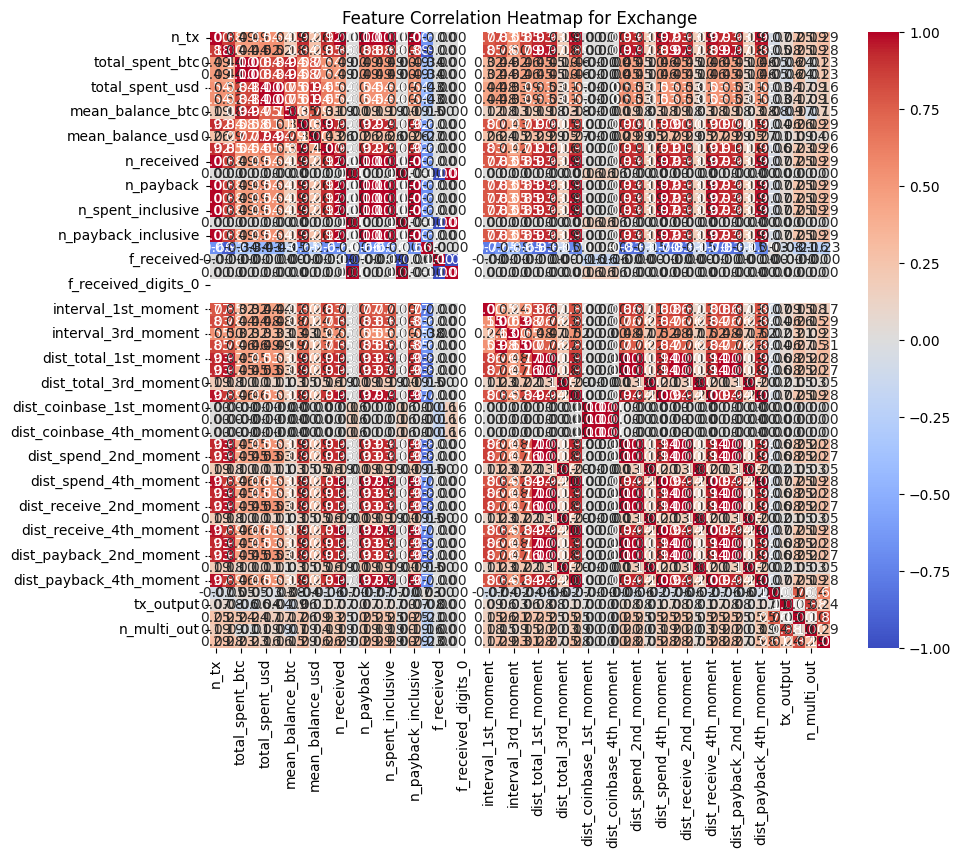

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


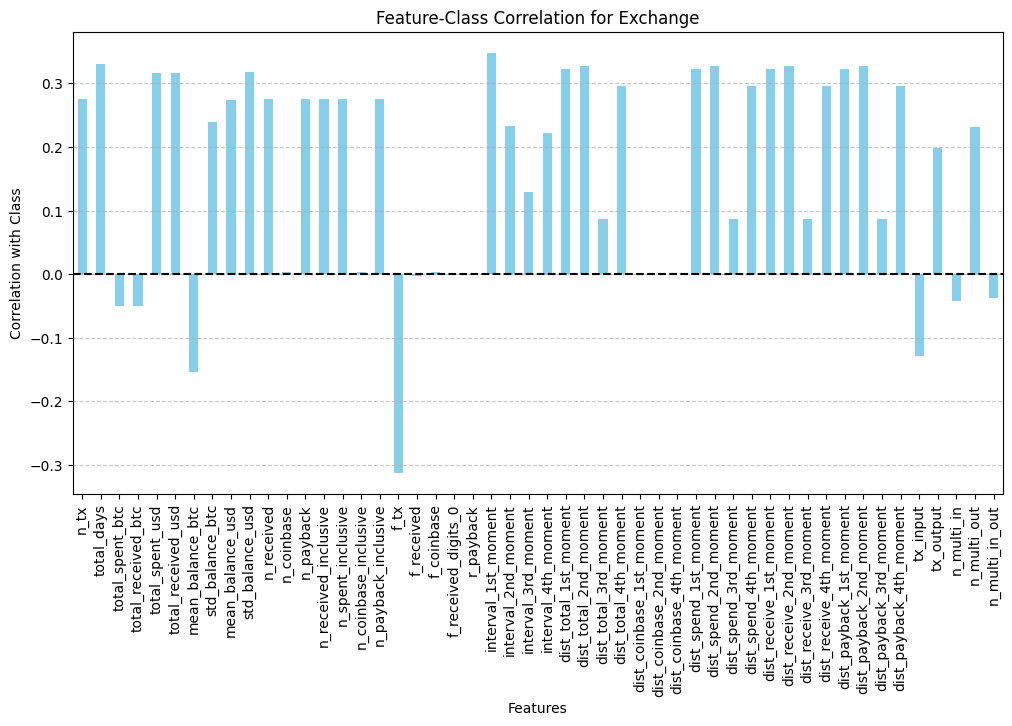

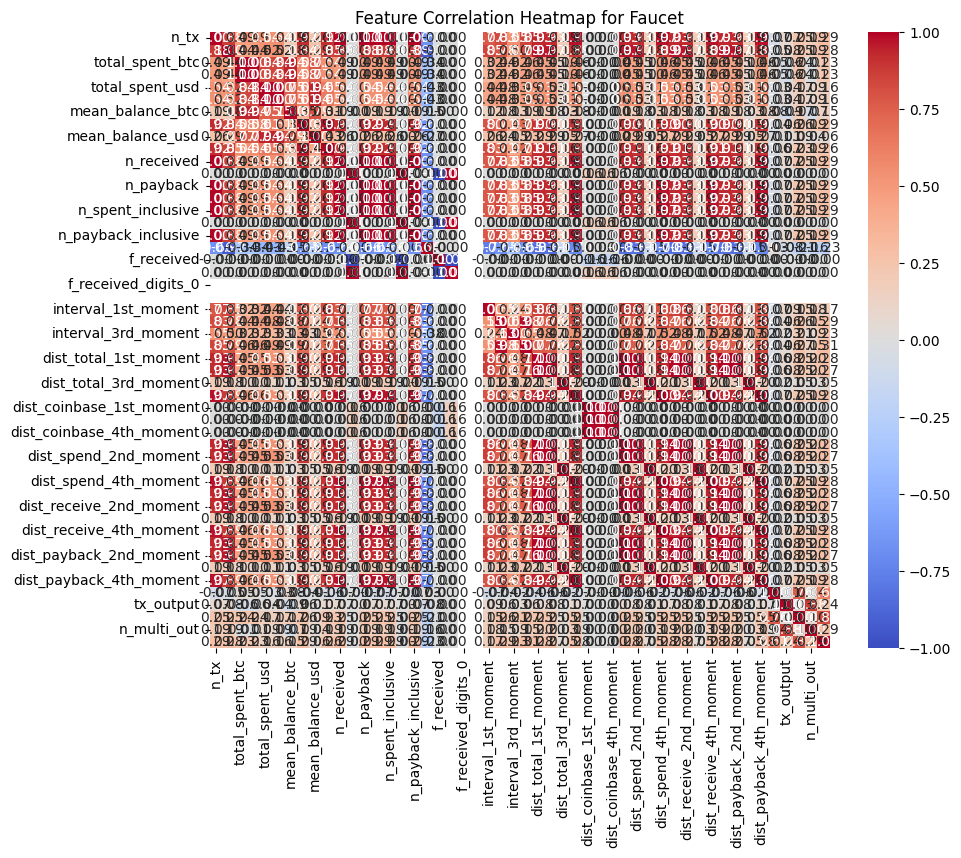

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


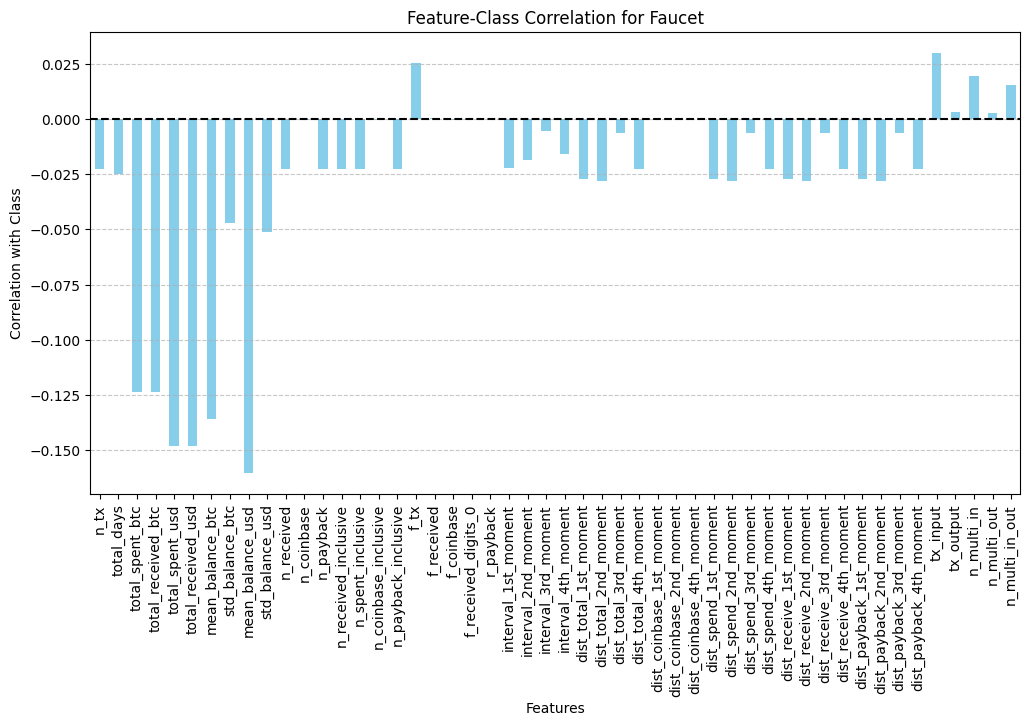

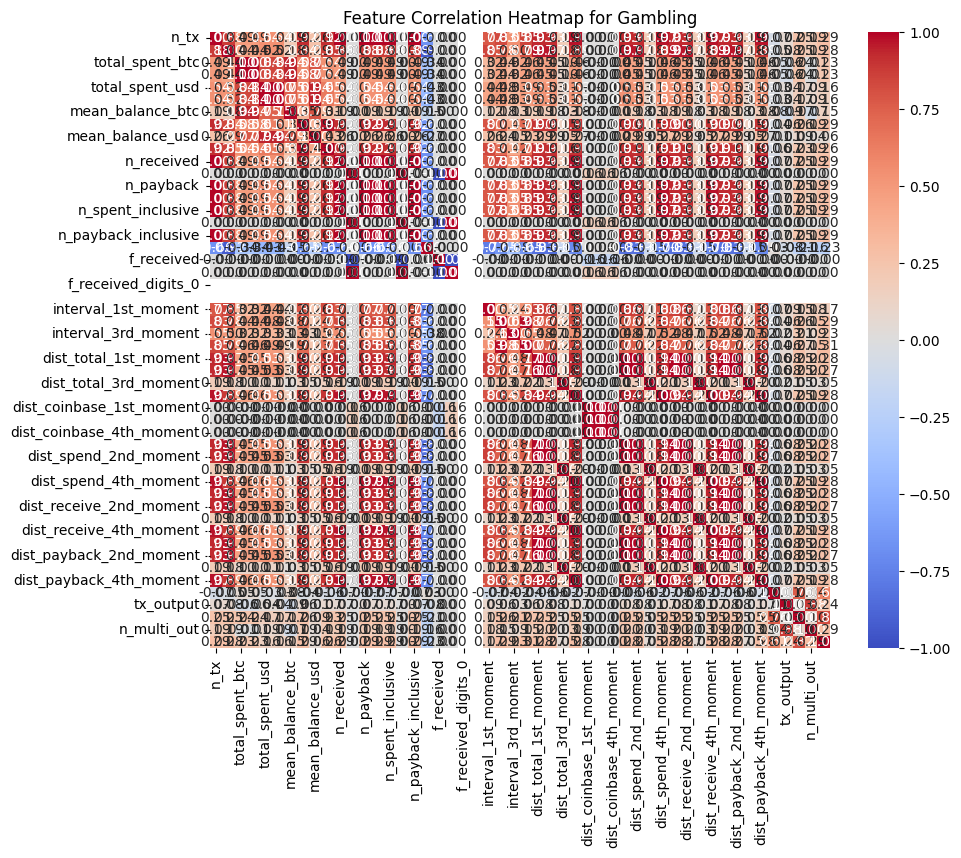

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


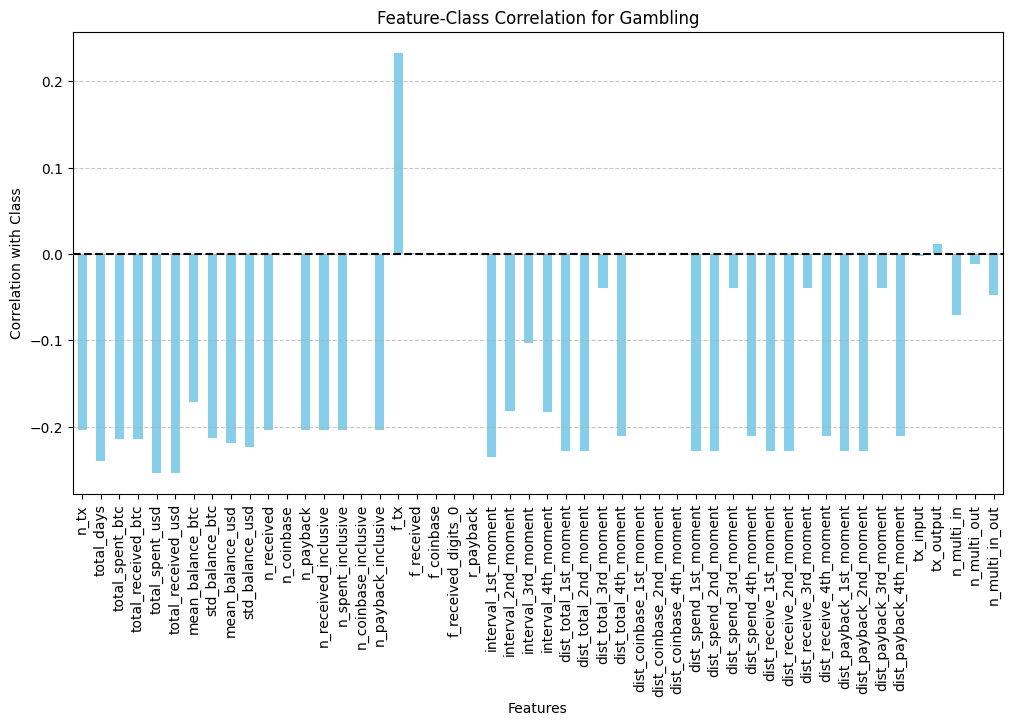

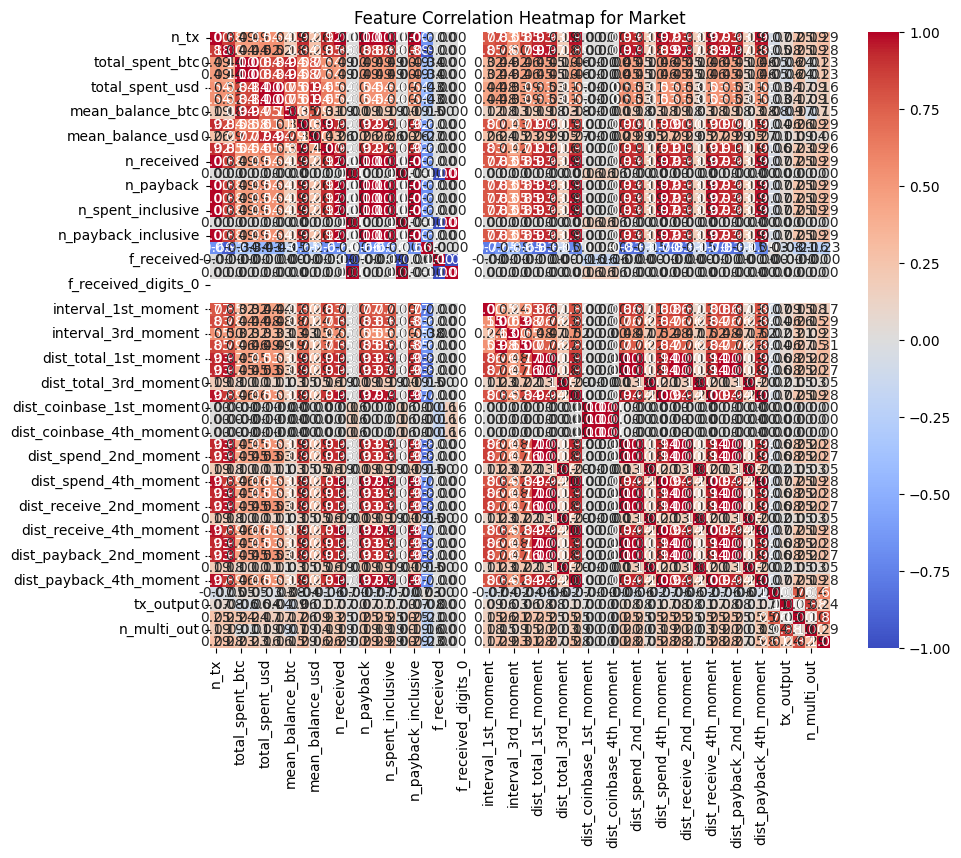

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


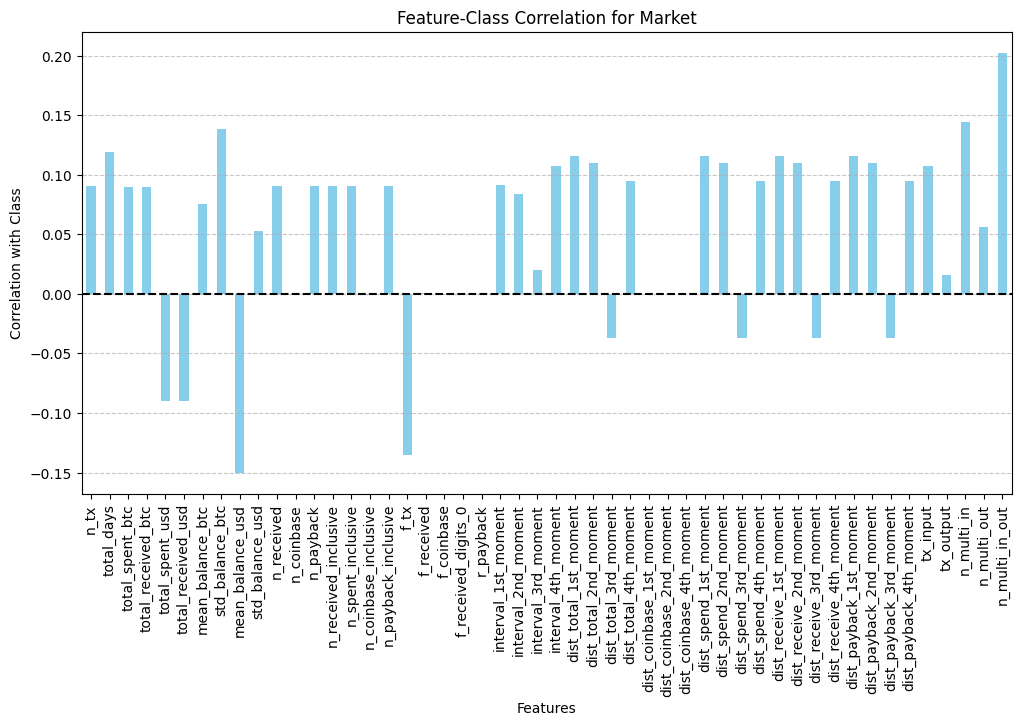

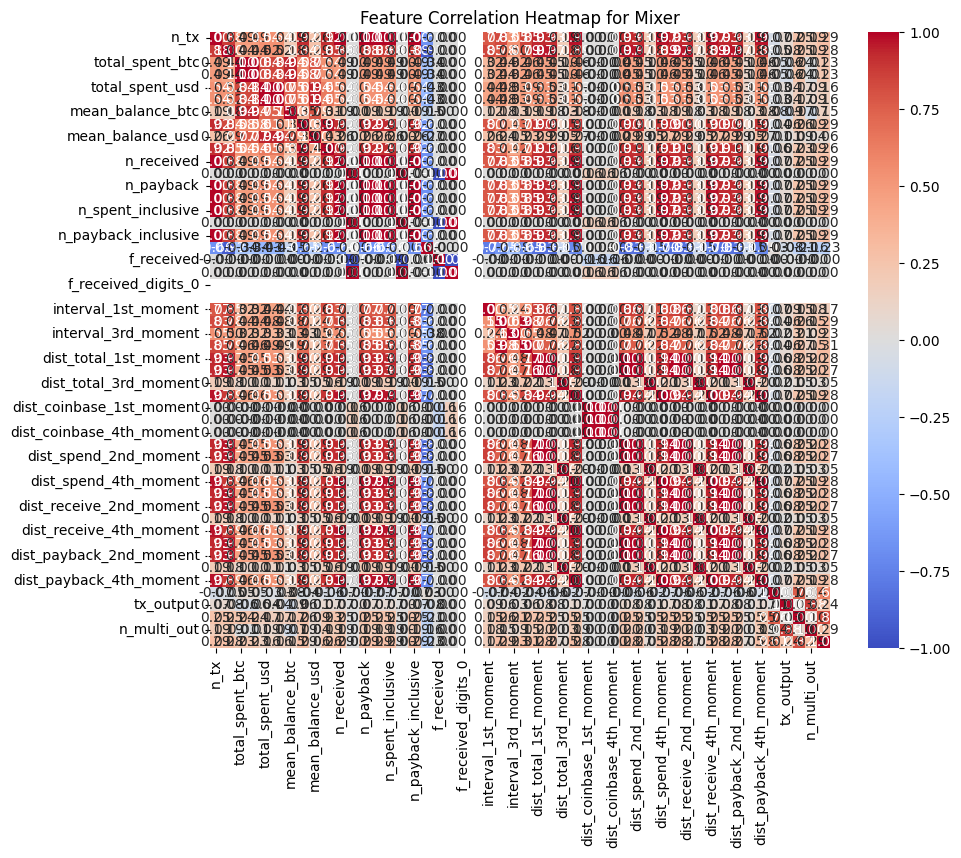

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


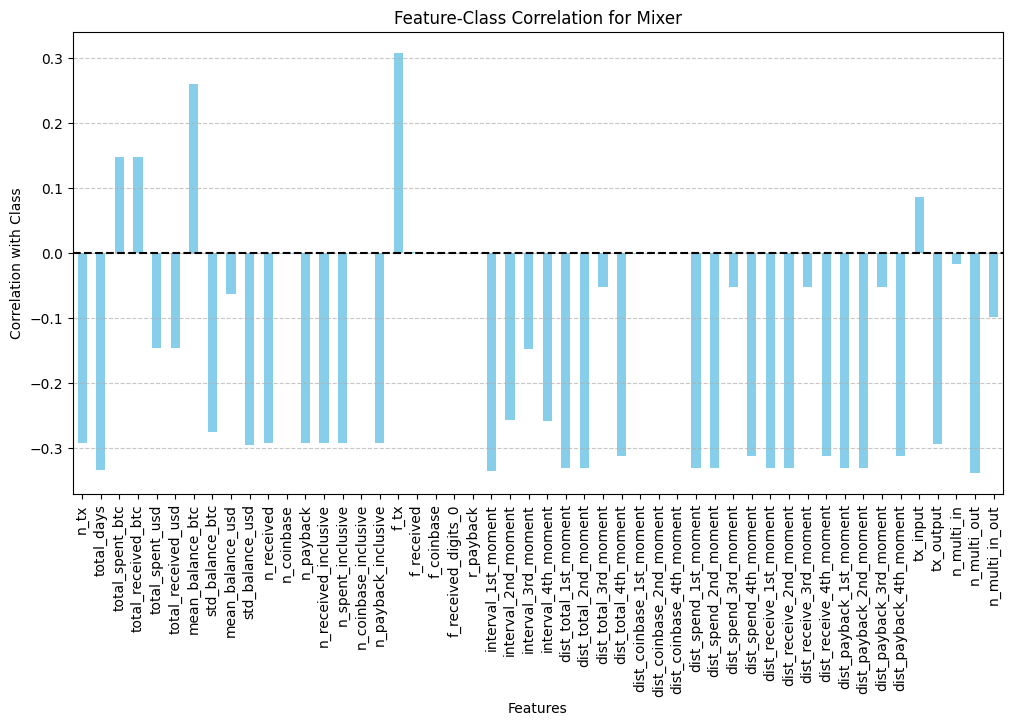

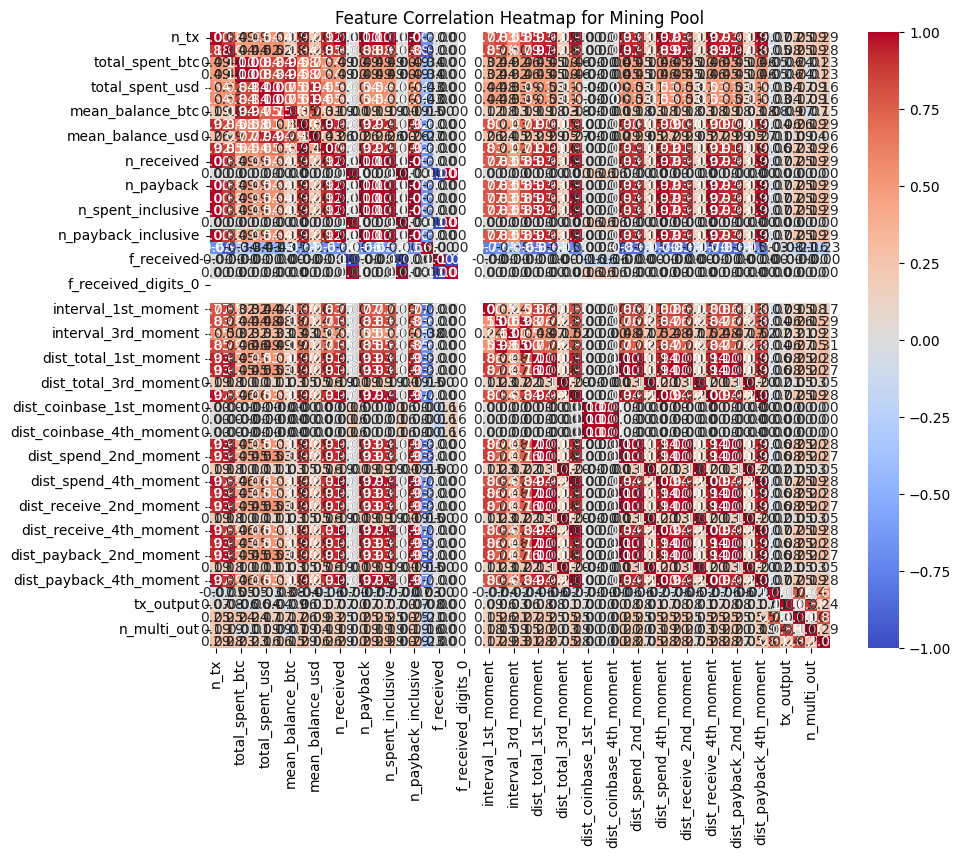

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


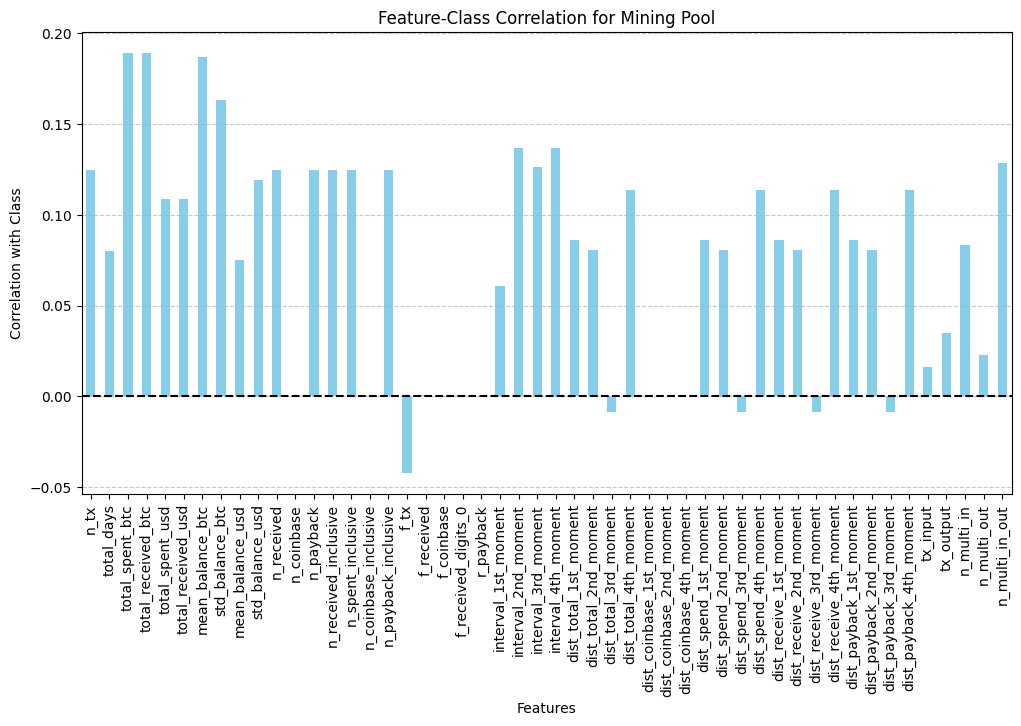

In [6]:
# 定義 class 索引和名稱的對應
class_names = {
    0: 'Exchange',
    1: 'Faucet',
    2: 'Gambling',
    3: 'Market',
    4: 'Mixer',
    5: 'Mining Pool'
}

# Load the CSV file
for i in range(0, 6):
    # Load the class 0~5 CSV file
    file_path = f'../data_p/quantum_data.address_class{i}.csv'
    df = pd.read_csv(file_path)

    # 移除包含空值的列
    df = df.dropna(axis=1)

    # Extracting each column as an array
    columns = df.columns
    features = df[columns[:-1]]  # All columns except the last one
    result = df[columns[-1]]    # The last column
    n_features = features.shape[1]

    # Calculate the correlation matrix for features
    feature_correlation = features.corr(method='spearman')
    # 繪製特徵相關性熱圖，並使用 class 名稱作為標題
    plot_feature_correlation_heatmap(feature_correlation, f'Feature Correlation Heatmap for {class_names[i]}')

    # Calculate the correlation of each feature with the result
    result_correlation = features.apply(lambda x: x.corr(result, method='spearman'))
    # 繪製特徵與結果類別相關性柱狀圖，並使用 class 名稱作為標題
    plot_feature_class_correlation_bar(result_correlation, f'Feature-Class Correlation for {class_names[i]}')

In [7]:
import pandas as pd

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()

# Loop through class0 to class5
for i in range(0, 6):
    # Read each file
    file_path = f'../data_p/quantum_qubo_data.address_class{i}.csv'
    df = pd.read_csv(file_path)

    # Remove rows where the last column (class{i}) has a value of 0
    df = df[df[df.columns[-1]] != 0]

    # Rename the last column to 'class', and set its value to the current class number for rows with 1
    df.rename(columns={df.columns[-1]: 'class'}, inplace=True)
    df['class'] = df['class'].apply(lambda x: i if x == 1 else x)

    # Add the DataFrame to the merged DataFrame
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Fill all NaN values with 0
merged_df.fillna(0, inplace=True)

# Read the comparison DataFrame
data_df = pd.read_csv('../data_p/data.address.csv')

# Identify missing columns in the merged DataFrame
missing_columns = set(data_df.columns) - set(merged_df.columns)

# Add missing columns to the merged DataFrame with default value 0
for col in missing_columns:
    merged_df[col] = 0

# Move the 'class' column to the end
class_column = merged_df.pop('class')
merged_df['class'] = class_column

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('../data_p/quantum_qubo_data.address.csv', index=False)


In [8]:
import pandas as pd

# 讀取原始數據
file_path = "../data_p/data.address.csv"
df = pd.read_csv(file_path)

# 將索引轉換為列選擇器
# selected_column_indices = list(all_selected_features)

# 只選擇 mixer 的特徵
selected_column_indices = list(class_selected_features[4])

selected_column_indices.append(len(df.columns) - 1)  # 添加最後一列的索引

# 使用 .iloc 來選擇指定索引的列
filtered_df = df.iloc[:, selected_column_indices]

# 確定原始數據集中哪些列不在處理過的數據集中
missing_columns = [col for col in df.columns[:-1] if col not in filtered_df.columns]  # 排除最後一列（class）

# 為缺失的列創建全為 0 的數據，並添加到處理過的數據集中
for col in missing_columns:
    filtered_df[col] = 0

# 重新排列列的順序以匹配原始數據集
filtered_df = filtered_df[df.columns]

# 將所有 NaN 值替換為 0
filtered_df.fillna(0, inplace=True)

# 保存修改後的數據集
filtered_df.to_csv("../data_p/all_selected_features_quantum_qubo_data.address.csv", index=False)


C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\2165311117.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = 0
C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\2165311117.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = 0
C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_376\2165311117.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea